In [203]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [202]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Numpy version:1.16.3
Pandas version:0.24.2
MatlpotLib version:2.2.2
Seaborn version:0.9.0
Sci-Kit Learn version:0.21.1
XGBoost version:0.90


In [175]:
xau_daily = pd.read_csv('./datasets/xau_daily.csv', index_col=0, parse_dates=True)
xau_daily.drop('time', axis='columns', inplace=True)
xau_daily.head()

,open,high,low,close,volume
date,,,,,
1998-04-22,310.30,314.40,310.0,313.5,561
1998-04-23,312.60,315.20,311.9,314.3,491
1998-04-24,313.40,314.20,311.8,312.9,431
1998-04-27,312.25,313.65,308.9,309.9,716
1998-04-28,309.39,310.90,306.3,308.2,802


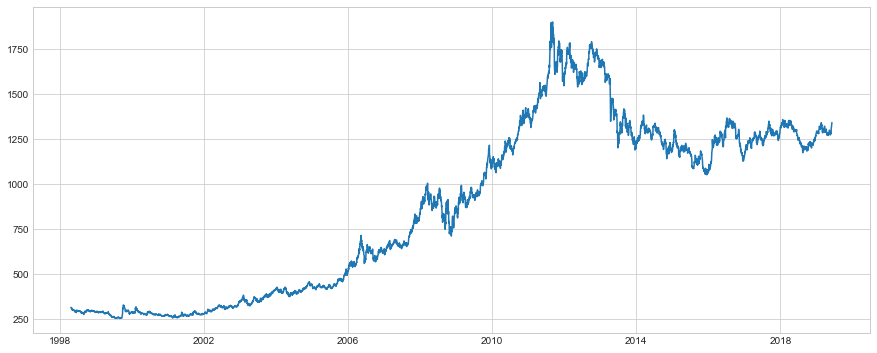

In [176]:
plt.figure(figsize=(15,6))
plt.plot(xau_daily.close)
plt.show()

In [17]:
xau_daily.columns = ["Open", "Close", "High", "Low", "Volume"]

In [18]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    
    # 49 original features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['Close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_90'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['Volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(window=252).mean().shift(1)
    
    #average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['Close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['Close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['Volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(window=252).std().shift(1)
    
    #standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['Close'] - df['Close'].shift(63)) / df['Close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(xau_daily)

In [19]:
data.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
date,,,,,,,,,,,,,,,,,,,,,
1999-04-15,281.70,283.50,284.90,280.50,281.7,701.0,283.77,283.485714,287.275397,292.885913,...,0.791183,0.001406,0.013518,-0.025816,-0.006278,-0.093830,0.002694,-0.000085,-0.000368,284.65
1999-04-16,283.65,281.70,284.65,280.85,283.8,551.0,284.27,283.350000,287.242857,292.764683,...,0.787615,-0.000878,0.008861,-0.009913,-0.007150,-0.096923,0.001771,-0.000099,-0.000382,285.40
1999-04-19,283.30,283.65,285.40,283.20,284.5,356.0,284.85,283.330952,287.215873,292.650397,...,0.772994,0.002635,0.010265,-0.001400,-0.005921,-0.091661,0.002050,-0.000080,-0.000359,285.45
1999-04-20,284.30,283.30,285.45,283.30,285.1,251.0,284.98,283.361905,287.176190,292.538492,...,0.777353,0.000175,0.002282,0.002282,-0.008682,-0.089909,0.000457,-0.000124,-0.000351,285.65
1999-04-21,284.10,284.30,285.65,283.55,284.7,381.0,285.21,283.411905,287.157937,292.438294,...,0.773211,0.000701,0.004042,0.003689,-0.004010,-0.081216,0.000808,-0.000049,-0.000313,284.80


In [20]:
data.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,...,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000,5226.000000
mean,894.682799,894.481596,901.539925,887.589686,894.714328,40454.963643,901.136671,899.582922,895.549356,877.800396,...,0.886631,0.000346,0.001772,0.007343,0.021171,0.084377,0.000346,0.000338,0.000329,901.743383
std,469.761970,469.798526,472.685876,466.365047,469.562677,44573.799120,472.675353,472.715255,472.873960,473.564215,...,0.307699,0.010019,0.024250,0.049723,0.076514,0.159178,0.004841,0.001183,0.000581,472.649235
min,252.200000,252.200000,253.200000,251.700000,252.600000,2.000000,254.890000,256.445238,258.042857,270.172698,...,0.212380,-0.063581,-0.135192,-0.194330,-0.229432,-0.288384,-0.028453,-0.004036,-0.001293,253.200000
25%,400.450000,400.400000,404.450000,397.350000,400.600000,1447.000000,404.238500,404.357143,402.464286,387.508006,...,0.655931,-0.004160,-0.011900,-0.022439,-0.031453,-0.030445,-0.002356,-0.000464,-0.000089,404.650000
50%,940.050000,940.000000,948.600000,931.845000,939.725000,18994.500000,947.842000,947.502619,930.840952,884.644841,...,0.850596,-0.000307,0.001668,0.003707,0.015123,0.068778,0.000355,0.000278,0.000310,948.650000
75%,1279.547500,1279.497500,1287.130000,1272.925000,1279.537500,73122.000000,1286.547000,1285.347024,1288.225397,1270.232550,...,1.086598,0.004925,0.015009,0.036491,0.065740,0.193006,0.003026,0.001055,0.000755,1287.190000
max,1901.670000,1901.670000,1920.680000,1874.270000,1900.020000,368056.000000,1892.036000,1858.998571,1766.864444,1693.577222,...,1.863572,0.149167,0.254497,0.337505,0.332785,0.736967,0.047685,0.004721,0.002237,1920.680000


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5226 entries, 1999-04-15 to 2019-06-07
Data columns (total 55 columns):
open                       5226 non-null float64
open_1                     5226 non-null float64
close_1                    5226 non-null float64
high_1                     5226 non-null float64
low_1                      5226 non-null float64
volume_1                   5226 non-null float64
avg_price_5                5226 non-null float64
avg_price_30               5226 non-null float64
avg_price_90               5226 non-null float64
avg_price_365              5226 non-null float64
ratio_avg_price_5_30       5226 non-null float64
ratio_avg_price_5_90       5226 non-null float64
ratio_avg_price_5_365      5226 non-null float64
ratio_avg_price_30_90      5226 non-null float64
ratio_avg_price_30_365     5226 non-null float64
ratio_avg_price_90_365     5226 non-null float64
avg_volume_5               5226 non-null float64
avg_volume_30              5226 non-null f

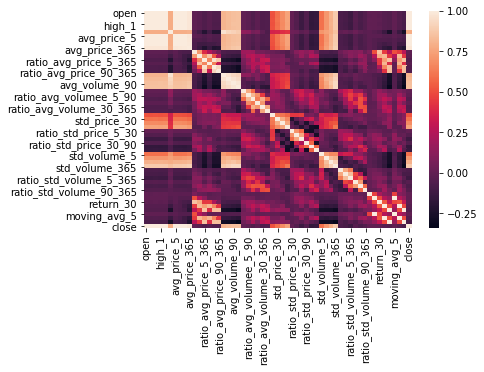

In [22]:
sns.heatmap(data.corr())

### SEGREGATING TRAIN AND TEST DATA

In [23]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(1999, 1, 1,0,0)
end_train = datetime.datetime(2017, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,...,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000,4856.000000
mean,865.544053,865.335855,872.453112,858.343919,865.597648,34662.227965,872.039160,870.417734,866.118366,846.939745,...,0.898705,0.000365,0.001864,0.007786,0.022533,0.090857,0.000364,0.000361,0.000354,872.663701
std,474.684226,474.717757,477.841113,470.975188,474.491022,40253.706593,477.825404,477.819762,477.788188,477.371717,...,0.313294,0.010291,0.024898,0.051087,0.078100,0.162622,0.004970,0.001207,0.000592,477.807457
min,252.200000,252.200000,253.200000,251.700000,252.600000,2.000000,254.890000,256.445238,258.042857,270.172698,...,0.212380,-0.063581,-0.135192,-0.194330,-0.229432,-0.288384,-0.028453,-0.004036,-0.001293,253.200000
25%,387.525000,387.300000,391.175000,383.525000,387.750000,1279.750000,390.900000,389.840476,389.407937,364.016379,...,0.664198,-0.004340,-0.012327,-0.023423,-0.031322,-0.027860,-0.002459,-0.000459,-0.000059,391.675000
50%,883.600000,883.350000,895.400000,874.250000,883.900000,9966.500000,894.680000,896.595238,882.662698,864.749603,...,0.868101,-0.000299,0.001868,0.004721,0.015419,0.077706,0.000400,0.000288,0.000349,895.750000
75%,1261.415000,1261.340000,1270.162500,1254.180000,1261.485000,64769.250000,1268.878000,1271.132500,1265.812659,1260.989226,...,1.103555,0.005133,0.015664,0.038209,0.069135,0.204652,0.003136,0.001111,0.000791,1270.212500
max,1901.670000,1901.670000,1920.680000,1874.270000,1900.020000,368056.000000,1892.036000,1858.998571,1766.864444,1693.577222,...,1.863572,0.149167,0.254497,0.337505,0.332785,0.736967,0.047685,0.004721,0.002237,1920.680000


In [24]:
#segregate data for validation
start_test = datetime.datetime(2018, 1, 1, 0, 0)
end_test = datetime.datetime(2019, 6, 7, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,1277.109162,1276.999757,1283.284703,1271.420622,1276.851081,116480.705405,1283.021849,1282.356315,1281.811223,1282.825579,...,0.728179,0.000105,0.000570,0.001524,0.003289,-0.000674,0.000111,0.000047,0.000006,1283.394568
std,47.846334,47.759828,48.030182,47.420811,47.857049,24013.666951,47.411649,46.043983,41.797087,14.476111,...,0.148761,0.005272,0.012991,0.025167,0.047933,0.054959,0.002596,0.000764,0.000217,48.132152
min,1173.770000,1173.770000,1181.910000,1160.110000,1173.680000,40626.000000,1189.684000,1200.746667,1209.623016,1261.315000,...,0.434512,-0.015886,-0.030524,-0.046731,-0.086960,-0.109576,-0.006169,-0.001434,-0.000446,1181.910000
25%,1230.815000,1230.815000,1235.922500,1224.410000,1230.682500,100080.000000,1234.309500,1234.615357,1243.882143,1269.383651,...,0.641160,-0.002681,-0.008242,-0.017197,-0.032445,-0.037116,-0.001650,-0.000513,-0.000136,1235.922500
50%,1287.715000,1287.715000,1294.310000,1282.955000,1287.855000,114310.000000,1294.613000,1291.680238,1295.482778,1280.983313,...,0.702030,-0.000410,0.000045,-0.002263,0.010322,-0.013367,0.000016,0.000182,-0.000041,1294.310000
75%,1316.937500,1316.635000,1322.692500,1310.552500,1316.532500,131826.000000,1321.259500,1319.088810,1311.739960,1296.458948,...,0.792253,0.002798,0.008163,0.018804,0.041906,0.042553,0.001634,0.000664,0.000181,1323.062500
max,1357.810000,1357.810000,1366.000000,1348.530000,1357.990000,234475.000000,1357.186000,1346.681429,1340.689365,1306.268214,...,1.095437,0.026426,0.045517,0.074701,0.094865,0.122821,0.008960,0.001447,0.000476,1366.000000


In [25]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4856, 54), (370, 54), (4856,), (370,))

### SCALING THE PREDICTOR DATA

In [26]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

### LINEAR REGRESSION (LIN)

In [34]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 5.306
MAE: 3.684
R^2: 0.988


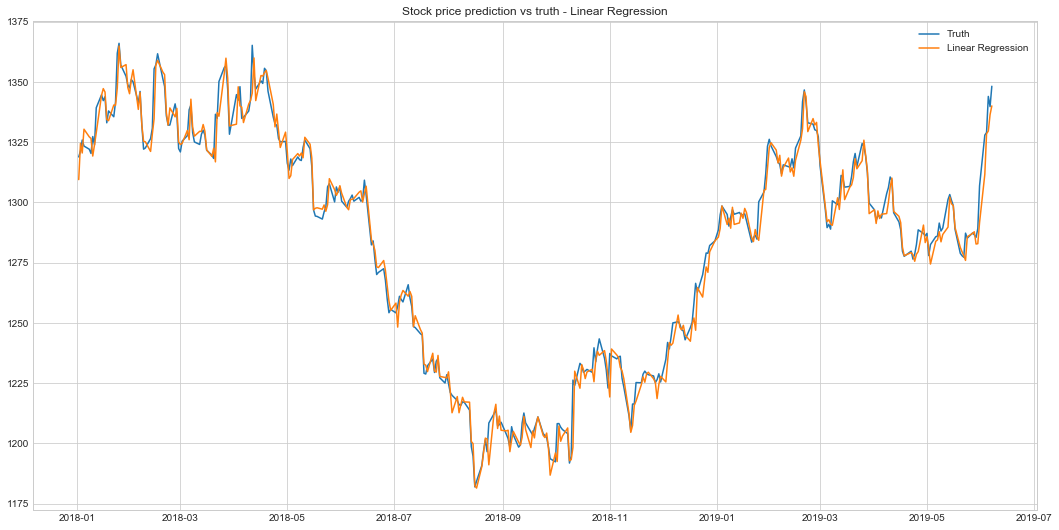

In [38]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price prediction vs truth - Linear Regression')
plt.show()

### SGD REGRESSOR (SGD)

In [36]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor(penalty='l2', max_iter=1000)
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 3e-05, 'eta0': 0.03}
RMSE: 6.869
MAE: 4.971
R^2: 0.980


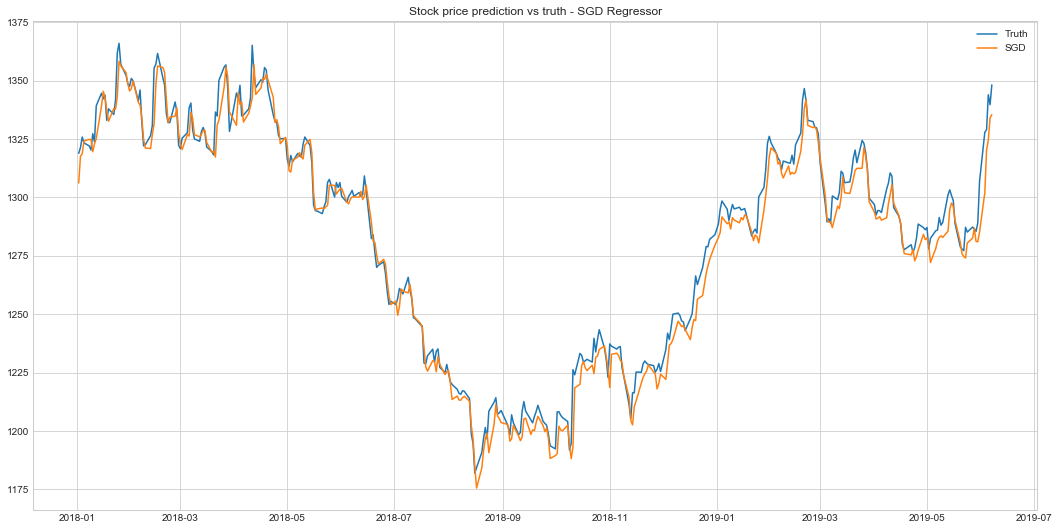

In [39]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price prediction vs truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

### Extreme Gradient Boosting Regressor (XGB)

In [98]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb_best)))

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.1min finished


[17:50:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5}
[17:50:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 6.459
MAE: 5.040
R^2: 0.982


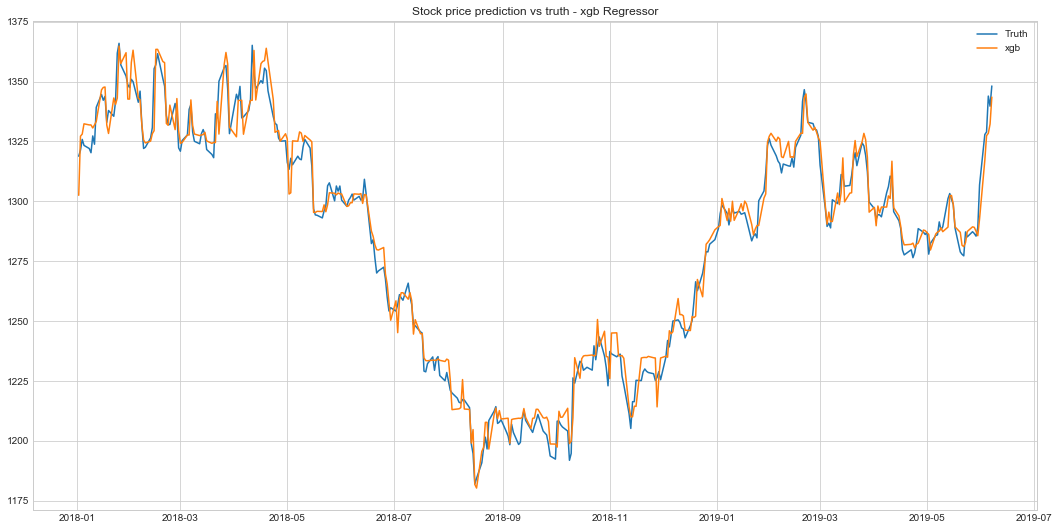

In [99]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Gold price prediction vs truth - xgb Regressor')
plt.show()

### Support Vector Regressor (SVR)

In [94]:
# Finally experiment with SVR
param_grid = {
              "C": [0.01, 0.1, 1, 100],
              "epsilon": [0.00001, 0.00003, 0.0001],
              }

from sklearn.svm import SVR
svr = SVR(kernel='linear')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

svr_best = grid_search.best_estimator_

predictions_svr = svr_best.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_svr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_svr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_svr)))

{'C': 100, 'epsilon': 3e-05}
RMSE: 6.084
MAE: 4.116
R^2: 0.984


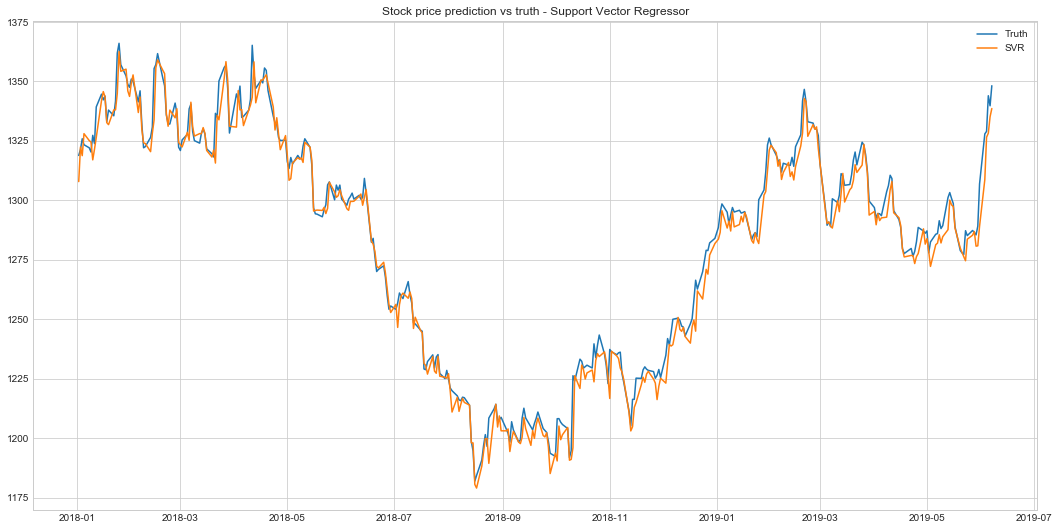

In [95]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_svr, = plt.plot(dates, predictions_svr)
plt.legend([plot_truth, plot_xgb], ['Truth', 'SVR'])
plt.title('Gold price prediction vs truth - Support Vector Regressor')
plt.show()

### Voting Regressor (VTR)

In [89]:
est = [('sgd',sgd_best), ('Lin',lin), ('xgb', xgb_best)]
vtr = VotingRegressor(estimators=est, n_jobs=-1)

vtr.fit(X_scaled_train, y_train)
predictions_vtr = vtr.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_vtr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_vtr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_vtr)))

RMSE: 5.442
MAE: 3.882
R^2: 0.987


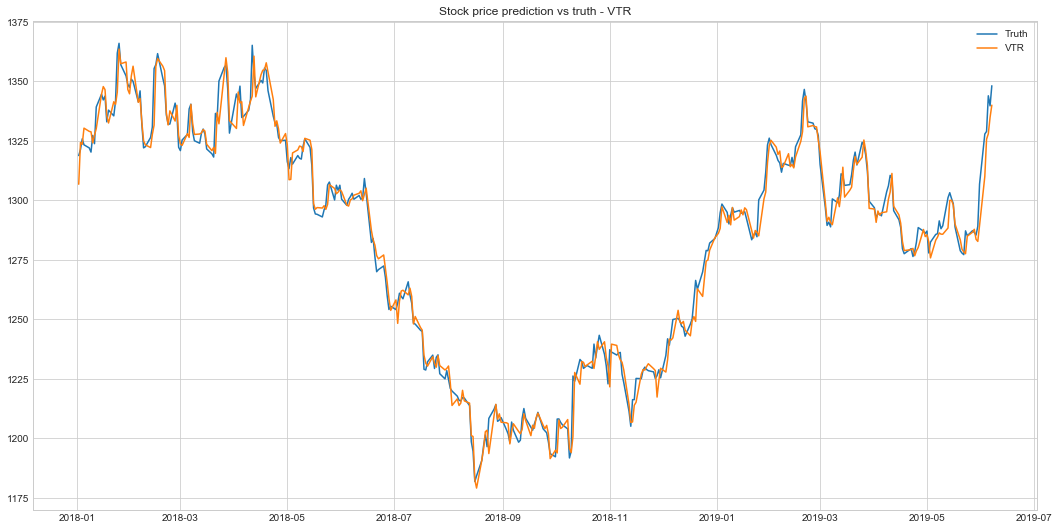

In [90]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_vtr, = plt.plot(dates, predictions_vtr)
plt.legend([plot_truth, plot_vtr], ['Truth', 'VTR'])
plt.title('Gold price prediction vs truth - VTR')
plt.show()

### Bagging Regressor (BGR)

In [77]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 5.270
MAE: 3.676
R^2: 0.988


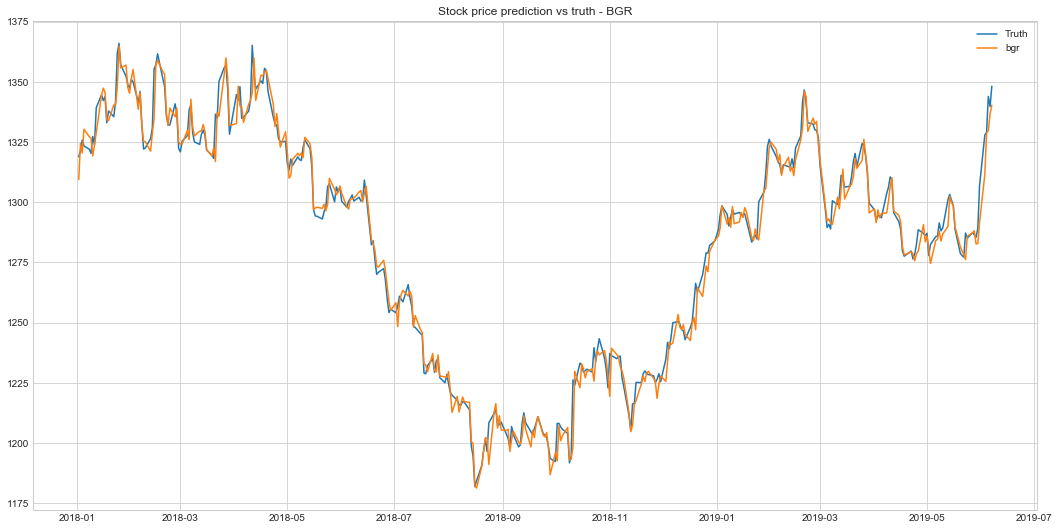

In [78]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price prediction vs truth - BGR')
plt.show()

### Random Forest Regressor (RF)

In [67]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf))*0.5)
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


{'max_depth': 50, 'min_samples_split': 5}
MSE: 40.915
MAE: 5.185
R^2: 0.982


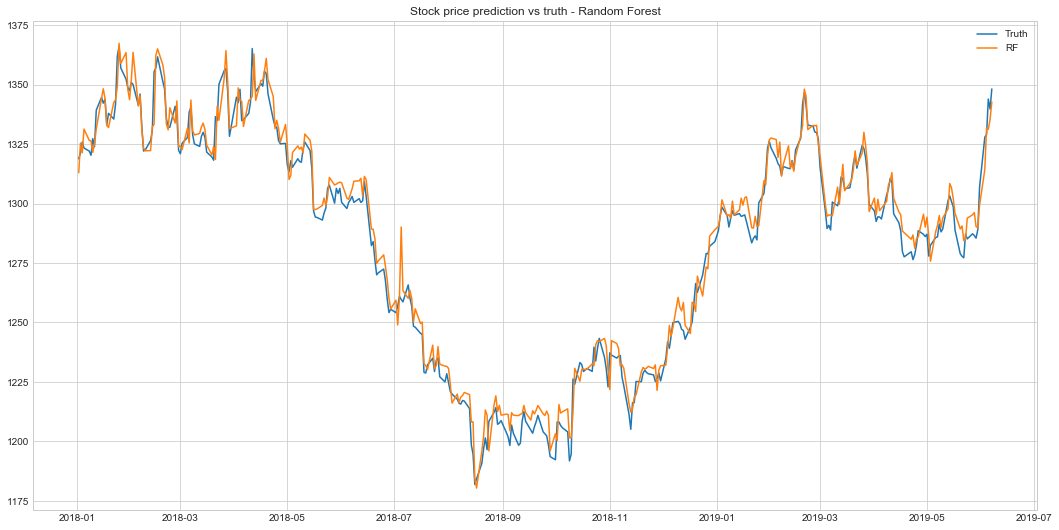

In [69]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price prediction vs truth - Random Forest')
plt.show()

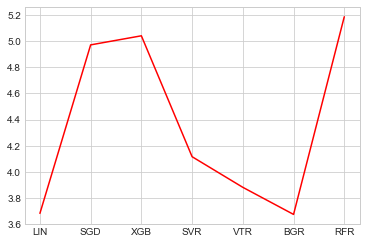

In [160]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                'SVR':mean_absolute_error(y_test, predictions_svr),
                'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})
plt.plot(mae_scoring, 'r')

In [173]:
#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
mae_min

BGR    3.675597
dtype: float64

### Saving, Loading and Predicting with the BGR Model

In [204]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_xauusd_10062019.pkl')

['bgr_xauusd_10062019.pkl']

In [205]:
#loading the saved model
model = joblib.load('bgr_xauusd_10062019.pkl')

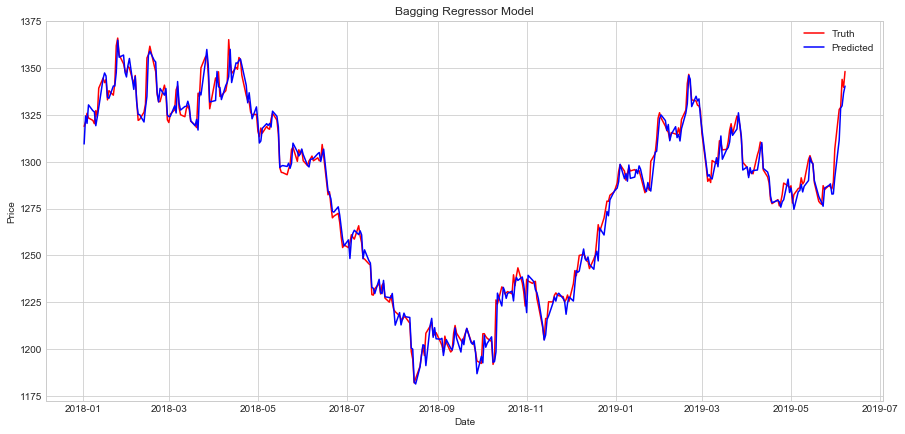

In [229]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()